LOADING AND DISPLAYINNG COVER IMAGE

In [1]:
import builtins
len = builtins.len

In [2]:
from PIL import Image
import numpy as np

def load_color_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_rgb = np.array(img, dtype=np.uint8)
    return img_rgb

def int_to_8bit_binary(value):
    return format(int(value), '08b')


def rgb_pixel_to_8bit(rgb_pixel):
    r, g, b = rgb_pixel
    return (
        int_to_8bit_binary(r),
        int_to_8bit_binary(g),
        int_to_8bit_binary(b)
    )


def image_rgb_to_8bit(img_rgb):
    H, W, _ = img_rgb.shape
    img_bin = [[[None, None, None] for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            r, g, b = img_rgb[i, j]
            img_bin[i][j][0] = int_to_8bit_binary(r)
            img_bin[i][j][1] = int_to_8bit_binary(g)
            img_bin[i][j][2] = int_to_8bit_binary(b)

    return img_bin


In [3]:
def preprocess_cover_to_8bit(image_path):
    img_rgb= load_color_image(image_path)
    img_bin= image_rgb_to_8bit(img_rgb)
    return img_bin

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def display_cover_image_binary(cover_img_bin, title="Cover Image", save_path=None):
    # cover_img_bin : (H,W,3) where each entry is an 8-bit string
    H = len(cover_img_bin)
    W = len(cover_img_bin[0])

    img = np.zeros((H, W, 3), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            img[i, j, 0] = int(cover_img_bin[i][j][0], 2)  # R
            img[i, j, 1] = int(cover_img_bin[i][j][1], 2)  # G
            img[i, j, 2] = int(cover_img_bin[i][j][2], 2)  # B

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


LOADING SECRET IMAGE AND CONVERSION TO 6BIT FORMAT

In [5]:
from PIL import Image
import numpy as np
import math

def load_gray_image(image_path):
    img = Image.open(image_path).convert("L")
    img_gray = np.array(img, dtype=np.uint8)
    return img_gray


def grayscale_to_8bit_binary(img_gray):
    H, W = img_gray.shape
    bin_img = [[None for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            bin_img[i][j] = format(int(img_gray[i, j]), '08b')
    return bin_img


def flatten_binary_image(bin_img):
    bitstream = []

    for row in bin_img:
        for pixel_bin in row:
            bitstream.extend([int(b) for b in pixel_bin])
    return bitstream



def split_to_6bit_blocks(bitstream):
    padding = (6 - (__builtins__.len(bitstream) % 6)) % 6
    bitstream = bitstream + [0] * padding

    blocks_6bit = []
    for i in range(0, __builtins__.len(bitstream), 6):
        blocks_6bit.append(bitstream[i:i+6])
    return blocks_6bit



def reshape_blocks_to_2d(blocks_6bit, W_cover):
    M = len(blocks_6bit)
    H_needed = math.ceil(M / W_cover)

    padded_blocks = blocks_6bit + [[0]*6] * (H_needed * W_cover - M)

    blocks_2d = []
    for y in range(H_needed):
        row = padded_blocks[y*W_cover : (y+1)*W_cover]
        blocks_2d.append(row)

    return blocks_2d


def pad_2d_to_power_of_two(blocks_2d):
    H = len(blocks_2d)
    W = len(blocks_2d[0])

    H2 = 1 << math.ceil(math.log2(H))
    W2 = 1 << math.ceil(math.log2(W))

    zero_block = [0]*6
    # Pad rows
    for row in blocks_2d:
        row.extend([zero_block] * (W2 - W))
    # Pad columns
    for _ in range(H2 - H):
        blocks_2d.append([zero_block] * W2)
    return blocks_2d


In [6]:
def preprocess_grayscale_to_6bit_2d(image_path,l):
    img_gray = load_gray_image(image_path)
    bin_img = grayscale_to_8bit_binary(img_gray)
    bitstream = flatten_binary_image(bin_img)
    blocks_6bit = split_to_6bit_blocks(bitstream)
    blocks_2d=reshape_blocks_to_2d(blocks_6bit,l)
    img_gray_6= pad_2d_to_power_of_two(blocks_2d)
    return img_gray_6


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def display_secret_before_decomposition(secret_path, title="Secret Image (Original)", save_path=None):
    
    img_gray = load_gray_image(secret_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_gray, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()



def display_secret_after_decomposition(img_gray_6, title="Secret Image After Decomposition", save_path=None):
    # img_gray_6 : (H,W,6)
    # Each 6-bit block is in (0–63).

    H = len(img_gray_6)
    W = len(img_gray_6[0])

    img = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            bits = img_gray_6[i][j]    
            value = int("".join(map(str, bits)), 2)
            img[i, j] = value               

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=63)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


LOADING BOTH IMAGES TO QC

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

def build_base_qc_CI_SI(img_bin, img_gray_6):
    # FORMAT ->
    # img_bin  : list[list[list[str]]]  (H,H,3) each str is 8-bit
    # img_gray : list[list[list[int]]]  (H,H,6)

    # Dimension verification
    H = len(img_bin)
    assert all(len(row) == H for row in img_bin)
    ky = kx = int(np.log2(H))
    assert 2**kx == H, "H must be power of 2"

    # Register creation
    y_c = QuantumRegister(ky, "y_c")
    x_c = QuantumRegister(kx, "x_c")
    cover_q = QuantumRegister(24, "CI")

    y_s = QuantumRegister(ky, "y_s")
    x_s = QuantumRegister(kx, "x_s")
    secret_q = QuantumRegister(6, "SI")
    si_rec = QuantumRegister(6, "si_rec")
    flag     = QuantumRegister(1, "flag")
    anc_x    = QuantumRegister(kx, "anc_x")
    anc_y    = QuantumRegister(ky, "anc_y")
    flag_x   = QuantumRegister(1, "fx")
    flag_y   = QuantumRegister(1, "fy")
    anc_gray = QuantumRegister(1, "ag")

    qc = QuantumCircuit(
        y_c, x_c, cover_q,
        y_s, x_s, secret_q,
        si_rec,flag, 
        anc_x, anc_y, flag_x, flag_y, anc_gray
    )

    # Load |CI⟩ into qc from given format cover image
    qc.h(y_c)
    qc.h(x_c)

    for y in range(H):
        y_bits = format(y, f"0{ky}b")
        for x in range(H):
            x_bits = format(x, f"0{kx}b")

            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y_c[i])
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x_c[i])

            controls = list(y_c) + list(x_c)

            for c in range(3):
                bits = img_bin[y][x][c]
                for b, bit in enumerate(bits):
                    if bit == "1":
                        qc.mcx(controls, cover_q[c*8 + b])

            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x_c[i])
            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y_c[i])

    # Load |SI⟩ into qc from given format decomposed secret image
    qc.h(y_s)
    qc.h(x_s)

    for y in range(H):
        y_bits = format(y, f"0{ky}b")
        for x in range(H):
            x_bits = format(x, f"0{kx}b")

            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y_s[i])
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x_s[i])

            controls = list(y_s) + list(x_s)

            for i, bit in enumerate(img_gray_6[y][x]):
                if bit == 1:
                    qc.mcx(controls, secret_q[i])

            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x_s[i])
            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y_s[i])

    return qc, {
        "y_c": y_c, "x_c": x_c, "cover_q": cover_q,
        "y_s": y_s, "x_s": x_s, "secret_q": secret_q,
        "si_rec":si_rec,"flag": flag,
        "anc_x": anc_x, "anc_y": anc_y,
        "flag_x": flag_x, "flag_y": flag_y,
        "anc_gray": anc_gray
    }


COMPARATOR CIRCUIT MAKING

1. equality_comparator -> for comparing any registers value
2. comparator_2d -> checking position equality

In [9]:
def equality_comparator(qc, reg_a, reg_b, flag, anc):
    # flag = 1 iff reg_a == reg_b
    # anc have same length as reg_a
    # All ancilla are returned to |0>

    k = len(reg_a)

    # anc[i] = a[i]^b[i]
    for i in range(k):
        qc.cx(reg_a[i], anc[i])
        qc.cx(reg_b[i], anc[i])

    # flag = XNOR(anc)
    qc.x(anc)
    qc.mcx(list(anc), flag)
    qc.x(anc)

    # uncompute anc
    for i in reversed(range(k)):
        qc.cx(reg_b[i], anc[i])
        qc.cx(reg_a[i], anc[i])


In [10]:
def comparator_2d(
    qc,
    x_c, y_c,
    x_s, y_s,
    flag,
    anc_x, anc_y,
    flag_x, flag_y
):
    # flag = 1 iff (x_c == x_s) AND (y_c == y_s)
    # All ancilla and intermediate flags are uncomputed afterwards

    # x comparison
    equality_comparator(qc, x_c, x_s, flag_x[0], anc_x)

    # y comparison
    equality_comparator(qc, y_c, y_s, flag_y[0], anc_y)

    # AND the results
    qc.ccx(flag_x[0], flag_y[0], flag)

    # uncompute y comparison
    equality_comparator(qc, y_c, y_s, flag_y[0], anc_y)

    # uncompute x comparison
    equality_comparator(qc, x_c, x_s, flag_x[0], anc_x)


EMBEDDING CIRCUIT

In [11]:
def controlled_embed_gray_lsb(qc, flag, b_hi, b_lo, secret, target, anc):
    # target ^= flag · (secret ⊕ (b_hi ⊕ b_lo)) = ((flag & secret)^(flag & anc)) 

    # anc = b_hi ⊕ b_lo (originally anc =|0>)
    qc.cx(b_hi, anc)
    qc.cx(b_lo, anc)

    # target ^= ((flag & secret)^(flag & anc)) is as follows :

    #1 target ^= (flag & secret)
    qc.mcx([flag, secret], target)

    #2 target ^= (flag & anc)
    qc.mcx([flag, anc], target)

    # uncompute anc
    qc.cx(b_lo, anc)
    qc.cx(b_hi, anc)


In [12]:
def controlled_full_pixel_gray_embedding(qc, cover_q, secret_q, flag, anc):
    # Embeds one secret pixel into one cover pixel iff flag == 1

    # for embedding s5,s4,s3 into r1,b1,g1
    controlled_embed_gray_lsb(qc, flag, cover_q[5],  cover_q[6],  secret_q[0], cover_q[6], anc)
    controlled_embed_gray_lsb(qc, flag, cover_q[13], cover_q[14], secret_q[1], cover_q[14], anc)
    controlled_embed_gray_lsb(qc, flag, cover_q[21], cover_q[22], secret_q[2], cover_q[22], anc)
    # for embedding s2,s1,s0 into r0,b0,g0
    controlled_embed_gray_lsb(qc, flag, cover_q[6],  cover_q[7],  secret_q[3], cover_q[7], anc)
    controlled_embed_gray_lsb(qc, flag, cover_q[14], cover_q[15], secret_q[4], cover_q[15], anc)
    controlled_embed_gray_lsb(qc, flag, cover_q[22], cover_q[23], secret_q[5], cover_q[23], anc)


In [13]:
def embed_full_secret_into_cover(
    qc,
    y_c, x_c, cover_q,
    y_s, x_s, secret_q,
    flag,
    anc_x, anc_y,
    flag_x, flag_y,
    anc_gray
):
    # apply position comparator
    comparator_2d(
        qc,
        x_c, y_c,
        x_s, y_s,
        flag,
        anc_x, anc_y,
        flag_x, flag_y)
    # applying embedding circuit
    controlled_full_pixel_gray_embedding(
        qc,
        cover_q,
        secret_q,
        flag[0],
        anc_gray[0] )
    # reverse the comparator
    comparator_2d(
        qc,
        x_c, y_c,
        x_s, y_s,
        flag,
        anc_x, anc_y,
        flag_x, flag_y)


In [14]:
def add_global_embedding_to_qc(qc, regs):
    embed_full_secret_into_cover(
        qc,
        regs["y_c"], regs["x_c"], regs["cover_q"],
        regs["y_s"], regs["x_s"], regs["secret_q"],
        regs["flag"],
        regs["anc_x"], regs["anc_y"],
        regs["flag_x"], regs["flag_y"],
        regs["anc_gray"]
    )
    return qc


EXTRACTION CIRCUIT 

In [15]:
def controlled_extract_gray_lsb(qc, flag, b_hi, b_lo, target, secret, anc):
    # secret ^= flag · (target ⊕ (b_hi ⊕ b_lo)) 

    # anc = b_hi ⊕ b_lo
    qc.cx(b_hi, anc)
    qc.cx(b_lo, anc)

    # secret ^= flag & target
    qc.mcx([flag, target], secret)

    # secret ^= flag & anc
    qc.mcx([flag, anc], secret)

    # uncompute anc
    qc.cx(b_lo, anc)
    qc.cx(b_hi, anc)


In [16]:
def controlled_full_pixel_gray_extraction(qc, cover_q, si_rec, flag, anc):
    # Extracts 6 secret bits given one cover pixel iff when flag == 1

    # inverse for s5,s4,s3 extraction
    controlled_extract_gray_lsb(qc, flag, cover_q[5],  cover_q[6],  cover_q[6],  si_rec[0], anc)
    controlled_extract_gray_lsb(qc, flag, cover_q[13], cover_q[14], cover_q[14], si_rec[1], anc)
    controlled_extract_gray_lsb(qc, flag, cover_q[21], cover_q[22], cover_q[22], si_rec[2], anc)
    # inverse for s2,s1,s0 extraction
    controlled_extract_gray_lsb(qc, flag, cover_q[6],  cover_q[7],  cover_q[7],  si_rec[3], anc)
    controlled_extract_gray_lsb(qc, flag, cover_q[14], cover_q[15], cover_q[15], si_rec[4], anc)
    controlled_extract_gray_lsb(qc, flag, cover_q[22], cover_q[23], cover_q[23], si_rec[5], anc)


In [17]:
def global_gray_extraction(
    qc,
    x_c, y_c, cover_q,
    x_s, y_s,
    si_rec,flag,
    anc_x, anc_y,
    flag_x, flag_y,
    anc_gray
):
    # position comparing
    comparator_2d(
        qc,
        x_c, y_c,
        x_s, y_s,
        flag,
        anc_x, anc_y,
        flag_x, flag_y)
    # apply extraction circuit
    controlled_full_pixel_gray_extraction(
        qc,
        cover_q,
        si_rec,
        flag[0],
        anc_gray[0])
    # reverse comparator
    comparator_2d(
        qc,
        x_c, y_c,
        x_s, y_s,
        flag,
        anc_x, anc_y,
        flag_x, flag_y)


In [18]:
def add_global_extraction_to_qc(qc, regs):
    global_gray_extraction(
        qc,
        regs["x_c"], regs["y_c"], regs["cover_q"],
        regs["x_s"], regs["y_s"],
        regs["si_rec"],regs["flag"],
        regs["anc_x"], regs["anc_y"],
        regs["flag_x"], regs["flag_y"],
        regs["anc_gray"]
    )
    return qc


MEASURING THE QC

In [19]:
from qiskit import ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

def measure_and_run_secret(qc,regs,shots=512,method="matrix_product_state"):
    # Measures output in the format:|y x>|s5 s4 s3 s2 s1 s0>

    y_s = regs["y_s"]
    x_s = regs["x_s"]
    si_rec = regs["si_rec"]

    ky = len(y_s)
    kx = len(x_s)

    cl = ClassicalRegister(ky + kx + 6, "cl_recons")
    qc.add_register(cl)
    idx=0
    # secret bits (MSB → LSB)
    for q in reversed(si_rec):
        qc.measure(q, cl[idx])
        idx+=1

    # x (MSB → LSB)
    for q in reversed(x_s):
        qc.measure(q, cl[idx])
        idx+=1

    # y (MSB → LSB)
    for q in reversed(y_s) :
        qc.measure(q, cl[idx])
        idx+=1

    backend = AerSimulator(method=method)
    tqc = transpile(qc, backend, optimization_level=3)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()
    return counts


In [20]:
def measure_and_run_secret_debug(qc, regs, shots=512, method="matrix_product_state"):
    y_c = regs["y_c"]
    x_c = regs["x_c"]
    y_s = regs["y_s"]
    x_s = regs["x_s"]
    si_rec = regs["si_rec"]
    flag = regs["flag"]

    ky = len(y_c)
    kx = len(x_c)

    cl = ClassicalRegister(2*(ky + kx) + 1 + 6, "cl_debug")
    qc.add_register(cl)

    idx = 0
    # y_c, x_c
    for i in range(ky):
        qc.measure(y_c[i], cl[idx]); idx += 1
    for i in range(kx):
        qc.measure(x_c[i], cl[idx]); idx += 1

    # y_s, x_s
    for i in range(ky):
        qc.measure(y_s[i], cl[idx]); idx += 1
    for i in range(kx):
        qc.measure(x_s[i], cl[idx]); idx += 1

    # flag
    qc.measure(flag[0], cl[idx]); idx += 1

    # secret bits (s5 → s0)
    for i in range(6):
        qc.measure(si_rec[5 - i], cl[idx]); idx += 1

    backend = AerSimulator(method=method)
    tqc = transpile(qc, backend, optimization_level=0)
    result = backend.run(tqc, shots=shots).result()
    return result.get_counts()


In [21]:
def display_the_hist(counts):
 if counts:
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}

    # Plot probability histogram
    plt.figure(figsize=(30, 10))
    bars = plt.bar(probabilities.keys(), probabilities.values(), color='blue', alpha=0.7)

    # Annotate bars with probability values
    for bar, prob in zip(bars, probabilities.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{prob:.4f}', 
                 ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.title("Probability Histogram")
    plt.xlabel("Measured Quantum States")
    plt.ylabel("Probability")
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
 else:
      print("No measurement data found for NEQR Encoded Image.")

COUNT TO RECONSTRUCTED SECRET IMAGE

In [22]:
# def counts_to_6bit_blocks(counts, ky, kx):
#     secret_blocks = {}

#     for bitstring, freq in counts.items():
#         bits = bitstring.replace(" ", "")  #Order followed :
#         y_bits = bits[:ky]                 # y_MSB → y_LSB
#         x_bits = bits[ky:ky + kx]          # x_MSB → x_LSB
#         s_bits = bits[-6:]                 # s5 s4 s3 s2 s1 s0
        
#         y = int(y_bits, 2)
#         x = int(x_bits, 2)
        
#         # list of 6bits
#         s = [int(b) for b in s_bits]       # [s5, s4, s3, s2, s1, s0]

#         secret_blocks[(y, x)] = s

#     return secret_blocks

"""Upper one uses directly the counts and not see dominant bits"""

from collections import defaultdict

def counts_to_6bit_blocks(counts, ky, kx):
    buckets = defaultdict(lambda: defaultdict(int))

    for bitstring, freq in counts.items():
        bits = bitstring.replace(" ", "")

        y_bits = bits[:ky]                 # y MSB → LSB
        x_bits = bits[ky:ky + kx]          # x MSB → LSB
        s_bits = bits[-6:]                 # s5 s4 s3 s2 s1 s0

        y = int(y_bits, 2)
        x = int(x_bits, 2)
        s = tuple(int(b) for b in s_bits)

        buckets[(y, x)][s] += freq

    # choose dominant secret per (y,x)
    secret_blocks = {}
    for (y, x), s_dict in buckets.items():
        secret_blocks[(y, x)] = list(
            max(s_dict.items(), key=lambda kv: kv[1])[0]
        )

    return secret_blocks


In [23]:
def collect_secret_6bit_blocks(secret_blocks,Hq, Wq,Hs, Ws):
    total_secret_bits = 8 * Hs * Ws
    needed_blocks = (total_secret_bits + 5) // 6 

    ordered_blocks = []
    for y in range(Hq):
        for x in range(Wq):
            if (y, x) in secret_blocks:
                ordered_blocks.append(secret_blocks[(y, x)])
            else:
                ordered_blocks.append([0]*6)

            if len(ordered_blocks) == needed_blocks:
                return ordered_blocks

    return ordered_blocks

# def collect_secret_6bit_blocks(secret_blocks, Hq, Wq, Hs, Ws):
#     total_secret_bits = 8 * Hs * Ws
#     needed_blocks = (total_secret_bits + 5) // 6

#     # allocate by linear index
#     ordered_blocks = [None] * needed_blocks

#     for (y, x), block in secret_blocks.items():
#         idx = y * Hq + x
#         if idx < needed_blocks:
#             ordered_blocks[idx] = block

#     # fill missing with zeros
#     for i in range(len(ordered_blocks)):
#         if ordered_blocks[i] is None:
#             ordered_blocks[i] = [0]*6

#     return ordered_blocks

# def collect_blocks_in_embedding_order(secret_blocks, Hq, Wq, Hs,Ws):
#     needed_blocks = (8 * Hs * Ws + 5) // 6
#     blocks = []
#     for y in range(Hq):
#         for x in range(Wq):
#             if (y, x) in secret_blocks:
#                 blocks.append(secret_blocks[(y, x)])
#                 if len(blocks) == needed_blocks:
#                     return blocks

#     return blocks



In [24]:
def blocks_to_bitstream(blocks_6bit):
    bitstream = []
    for blk in blocks_6bit:
        bitstream.extend(blk)
    return bitstream

def bitstream_to_pixels(bitstream, Hs, Ws):
    total_pixels = Hs * Ws
    pixels = []
    bitstream = bitstream[:8*total_pixels]  
    for i in range(0, 8 * total_pixels, 8):
        byte = bitstream[i:i+8]
        value = 0
        for b in byte:
            value = (value << 1) | b
        pixels.append(value)
        # pixels.append(int("".join(map(str, byte)), 2))

    return np.array(pixels, dtype=np.uint8).reshape(Hs, Ws)

In [25]:
def reconstruct_secret_grayscale(counts,ky, kx ,Hq, Wq,Hs,Ws):
    # Making 6bit blocks
    secret_blocks = counts_to_6bit_blocks(counts, ky, kx)

    # collect only required 6-bit blocks
    blocks_6bit = collect_secret_6bit_blocks(secret_blocks, Hq, Wq, Hs, Ws)
    bitstream = blocks_to_bitstream(blocks_6bit)
    
    # REMOVE PADDED ZEROS 
    total_bits_needed = Hs * Ws * 8
    bitstream = bitstream[:total_bits_needed]
    assert len(bitstream) % 8 == 0

    # Back from bitstream to grayscale image
    img_rec = bitstream_to_pixels(bitstream, Hs, Ws)
    return img_rec


DISPLAYING AND COMPARING THE RECONSTRUCTED IMAGE

In [26]:
def display_and_compare_grayscale(original_img,reconstructed_img,show_diff=True):
    
    assert original_img.shape == reconstructed_img.shape #Both shoould be of same shape
    orig = original_img.astype(int)
    recon = reconstructed_img.astype(int)
    diff = np.abs(orig - recon)
    # Metrics
    mae = np.mean(diff)
    mse = np.mean((orig - recon) ** 2)
    max_err = np.max(diff)

    if mse == 0:
        psnr = float("inf")
    else:
        psnr = 20 * math.log10(255.0 / math.sqrt(mse))

    print("Reconstruction Error Metrics are as follows :")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Max Pixel Error : {max_err}")
    print(f"PSNR (dB) : {psnr:.2f}")

    if show_diff:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img, cmap="gray", vmin=0, vmax=255)
    axes[0].set_title("Original Grayscale Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_img, cmap="gray", vmin=0, vmax=255)
    axes[1].set_title("Reconstructed Grayscale Image")
    axes[1].axis("off")

    if show_diff:
        axes[2].imshow(diff, cmap="hot")
        axes[2].set_title("Absolute Difference Image")
        axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return {"MAE": mae,"MSE": mse,"MAX_ERROR": max_err,"PSNR": psnr}



DISPLAYING THE CIRCUITS AT ANY STAGE 

In [27]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import circuit_drawer
from IPython.display import display

def display_large_circuit(qc, regs, name,fold=250):
    print(f"Below is given the {name}")
    shadow_regs = {}
    for name, reg in regs.items():
        shadow_regs[name] = QuantumRegister(len(reg), name)

    qc_shadow = QuantumCircuit(*shadow_regs.values())

    for inst, qargs, cargs in qc.data:
        new_qargs = []
        for q in qargs:
            idx = qc.qubits.index(q)
            new_qargs.append(qc_shadow.qubits[idx])
        qc_shadow.append(inst, new_qargs, cargs)


    fig = circuit_drawer(qc_shadow,output="mpl",fold=fold)
    width = max(30, len(qc_shadow.qubits) *1)
    height = max(10, qc_shadow.depth() * 1)
    fig.set_size_inches(width, height)

    display(fig)


MASTER FUNCTION THAT IMPLEMENTS ABOVE ALL

In [28]:
def master_function(color_path,secret_path):

    # Loading and display cover image
    img_rgb = load_color_image(color_path)
    img_bin = preprocess_cover_to_8bit(color_path)
    display_cover_image_binary(img_bin)

    # Loading and displaying Original and Decomposed secret image
    img_gray = load_gray_image(secret_path)
    display_secret_before_decomposition(secret_path)
    img_gray_6 = preprocess_grayscale_to_6bit_2d(secret_path,len(img_bin))
    display_secret_after_decomposition(img_gray_6)

    #Loading the values to QC
    qc ,regs = build_base_qc_CI_SI(img_bin,img_gray_6)
    # Displaying
    display_large_circuit(qc, regs,"Loader Circuit")
    qc.barrier()

    # Embedding circuit application
    qc = add_global_embedding_to_qc(qc,regs)
    # Displaying
    display_large_circuit(qc,regs,"After Embedding")
    qc.barrier()

    # Extraction circuit
    qc = add_global_extraction_to_qc(qc,regs)
    # Displaying
    display_large_circuit(qc,regs,"After Extraction")
    
    # Measuring the circuit
    counts = measure_and_run_secret(qc,regs,shots=1024)
    cnt2 = measure_and_run_secret_debug(qc,regs,shots=1024)
    print(cnt2)
    # Histogram
    display_the_hist(counts)
    display_the_hist(cnt2)

    # Reconstruction of secret image
    img_rec = reconstruct_secret_grayscale(counts,
                                           ky=len(regs['y_s']),kx= len(regs['x_s']),
                                           Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                           Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )
    
    # Displaying and comparing the Original and Reconstruction Image
    metrics = display_and_compare_grayscale(img_gray,img_rec,show_diff=True) 
    print(metrics)



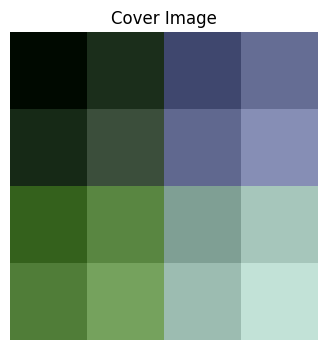

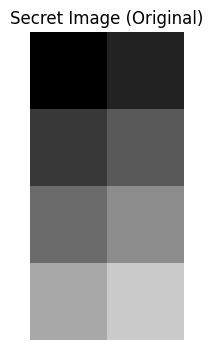

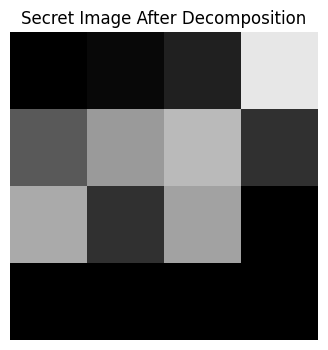

Below is given the Loader Circuit


C:\Users\sahi1\AppData\Local\Temp\ipykernel_21672\791540687.py:13: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


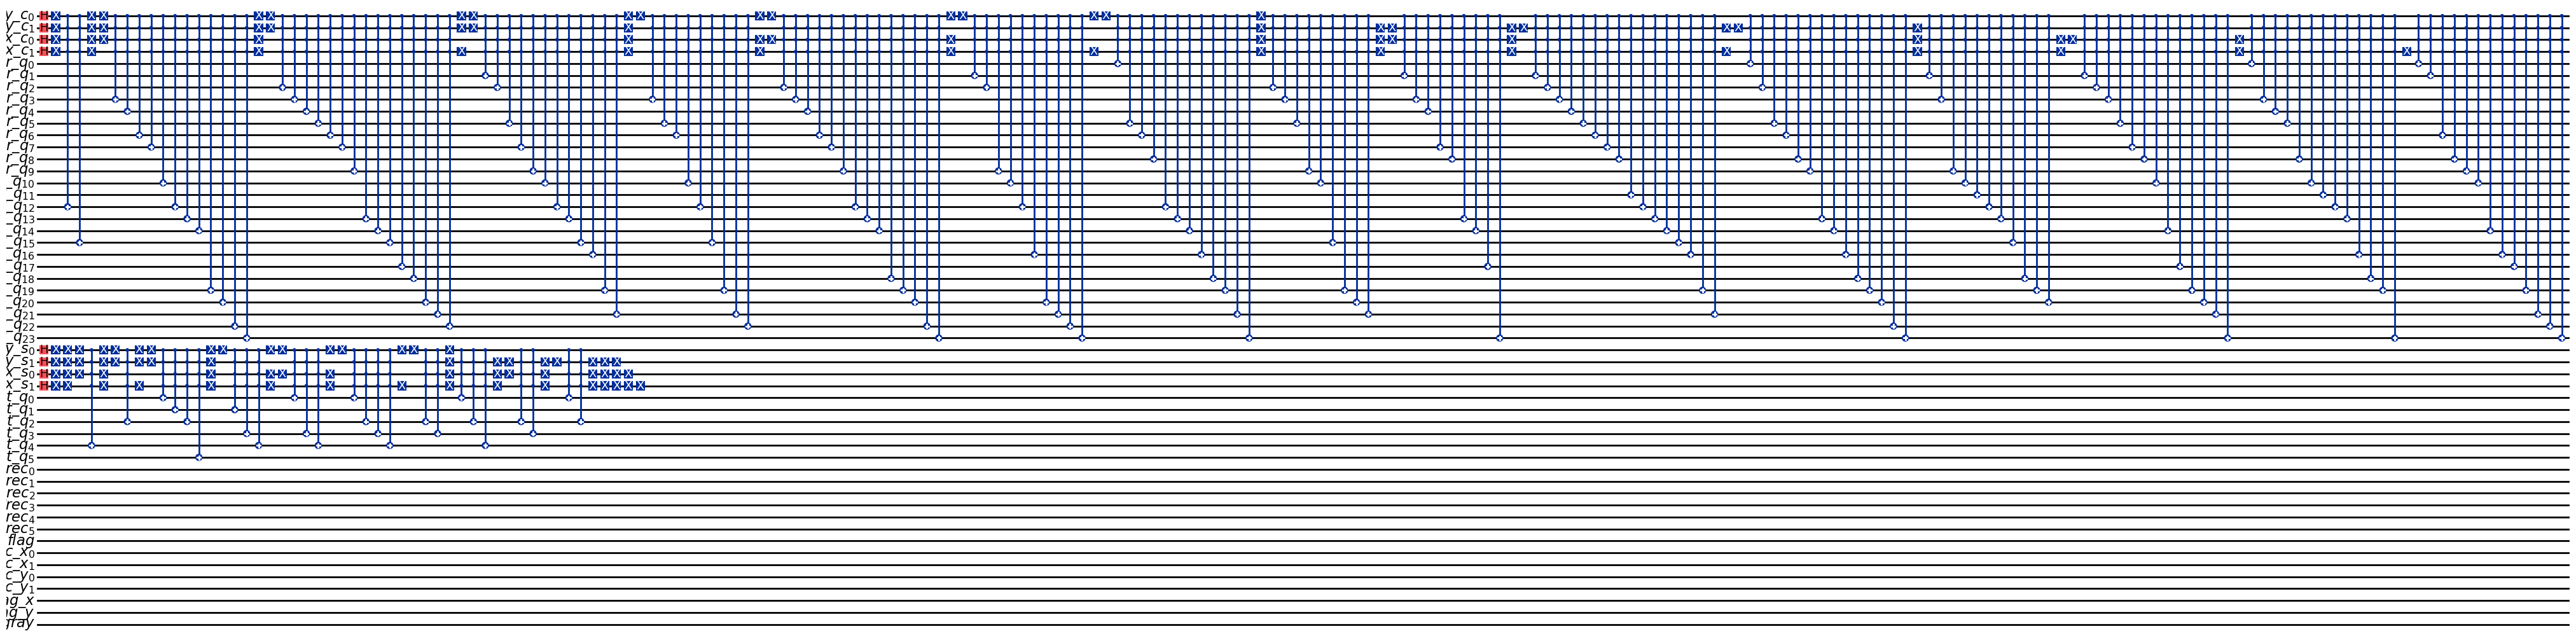

Below is given the After Embedding


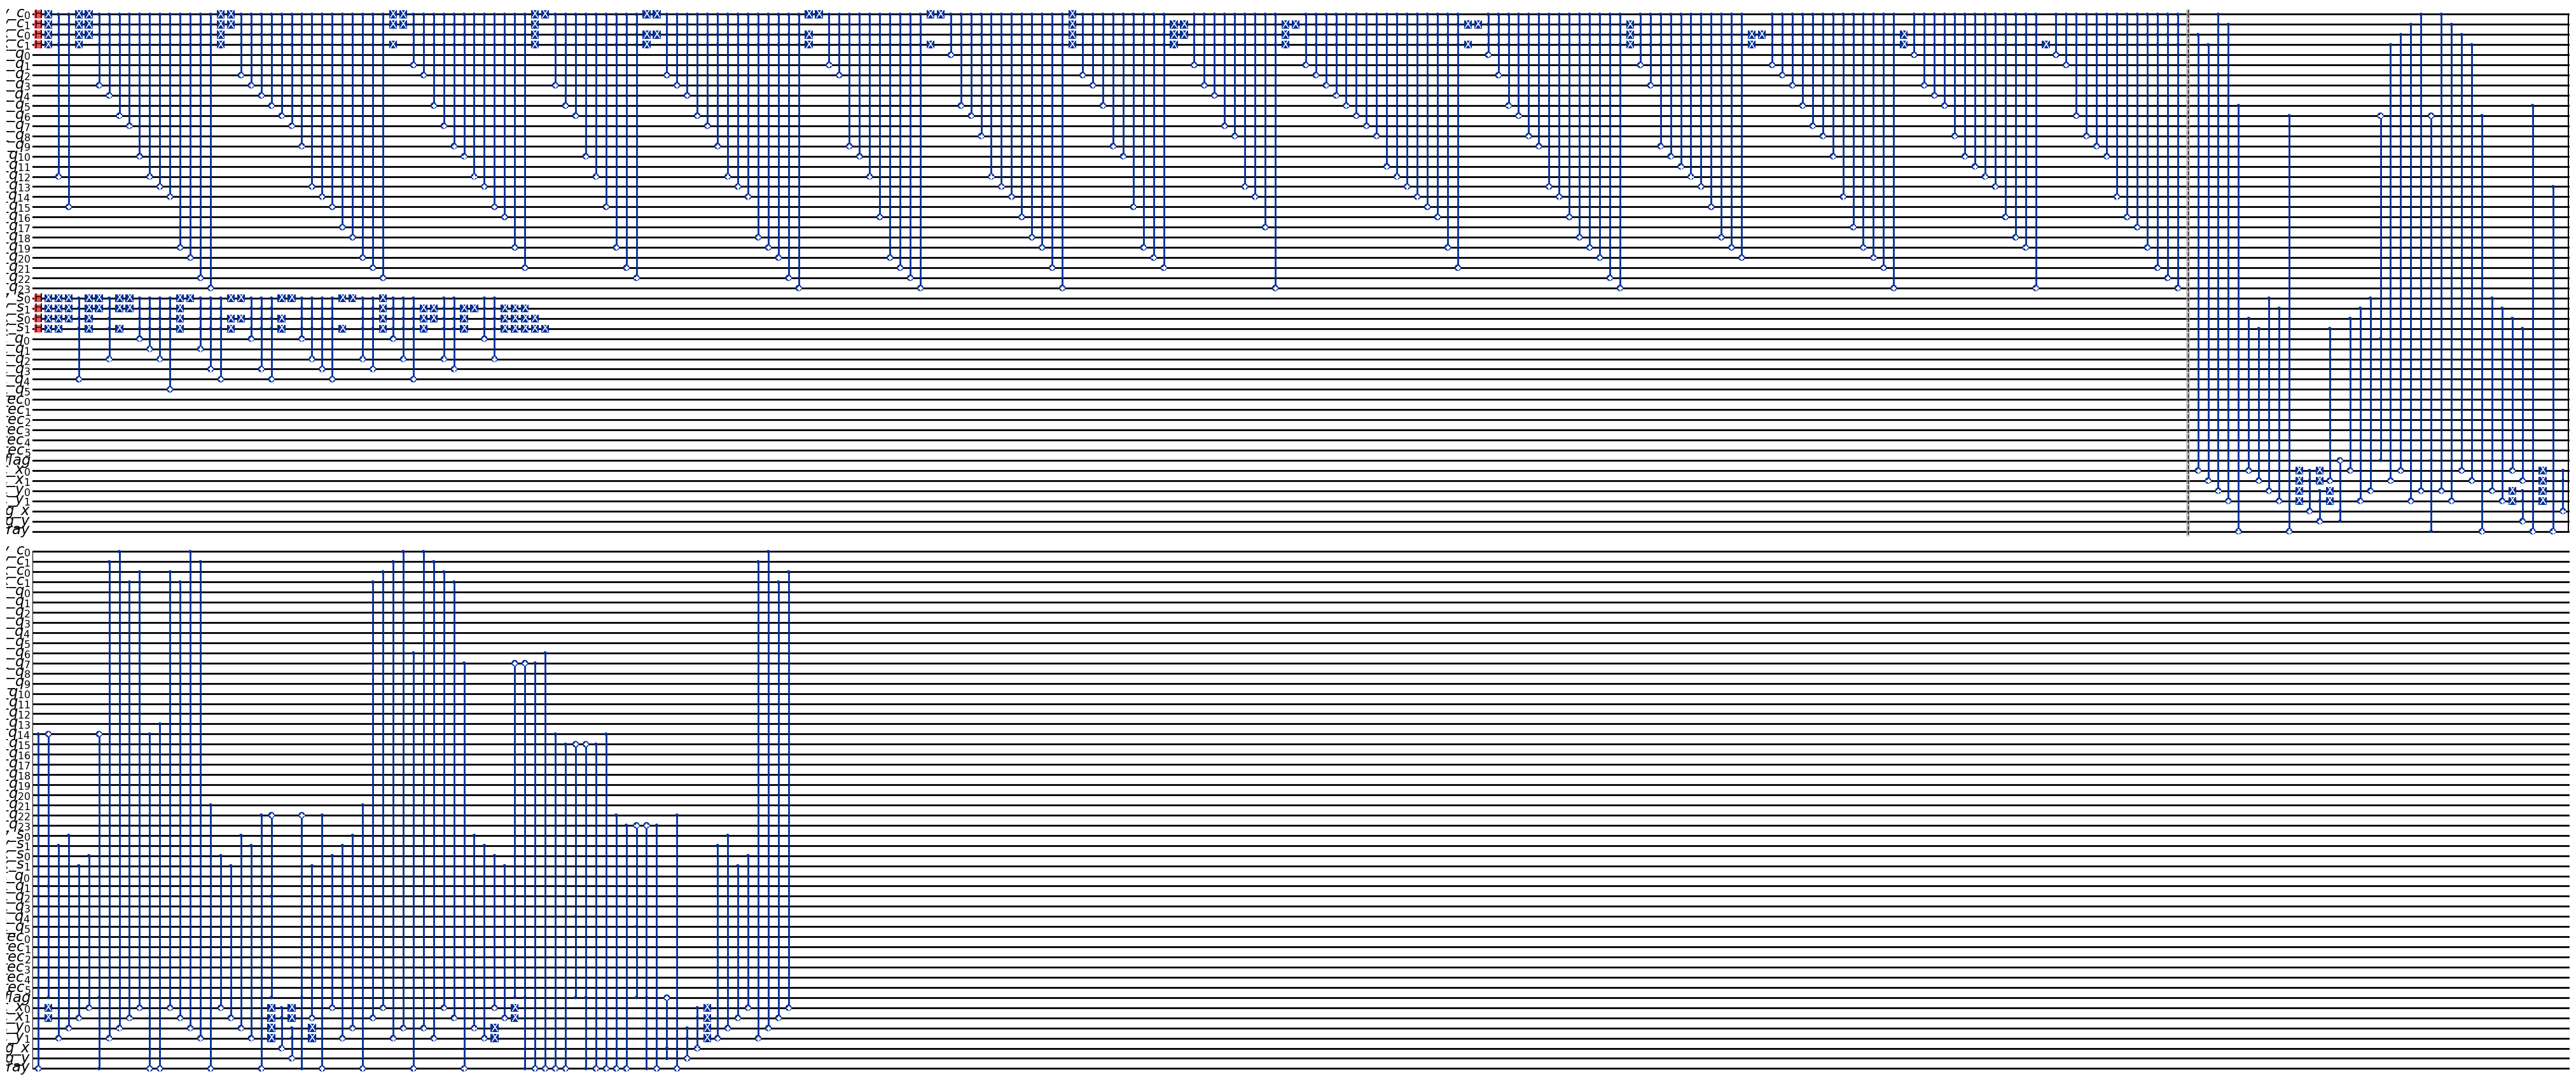

Below is given the After Extraction


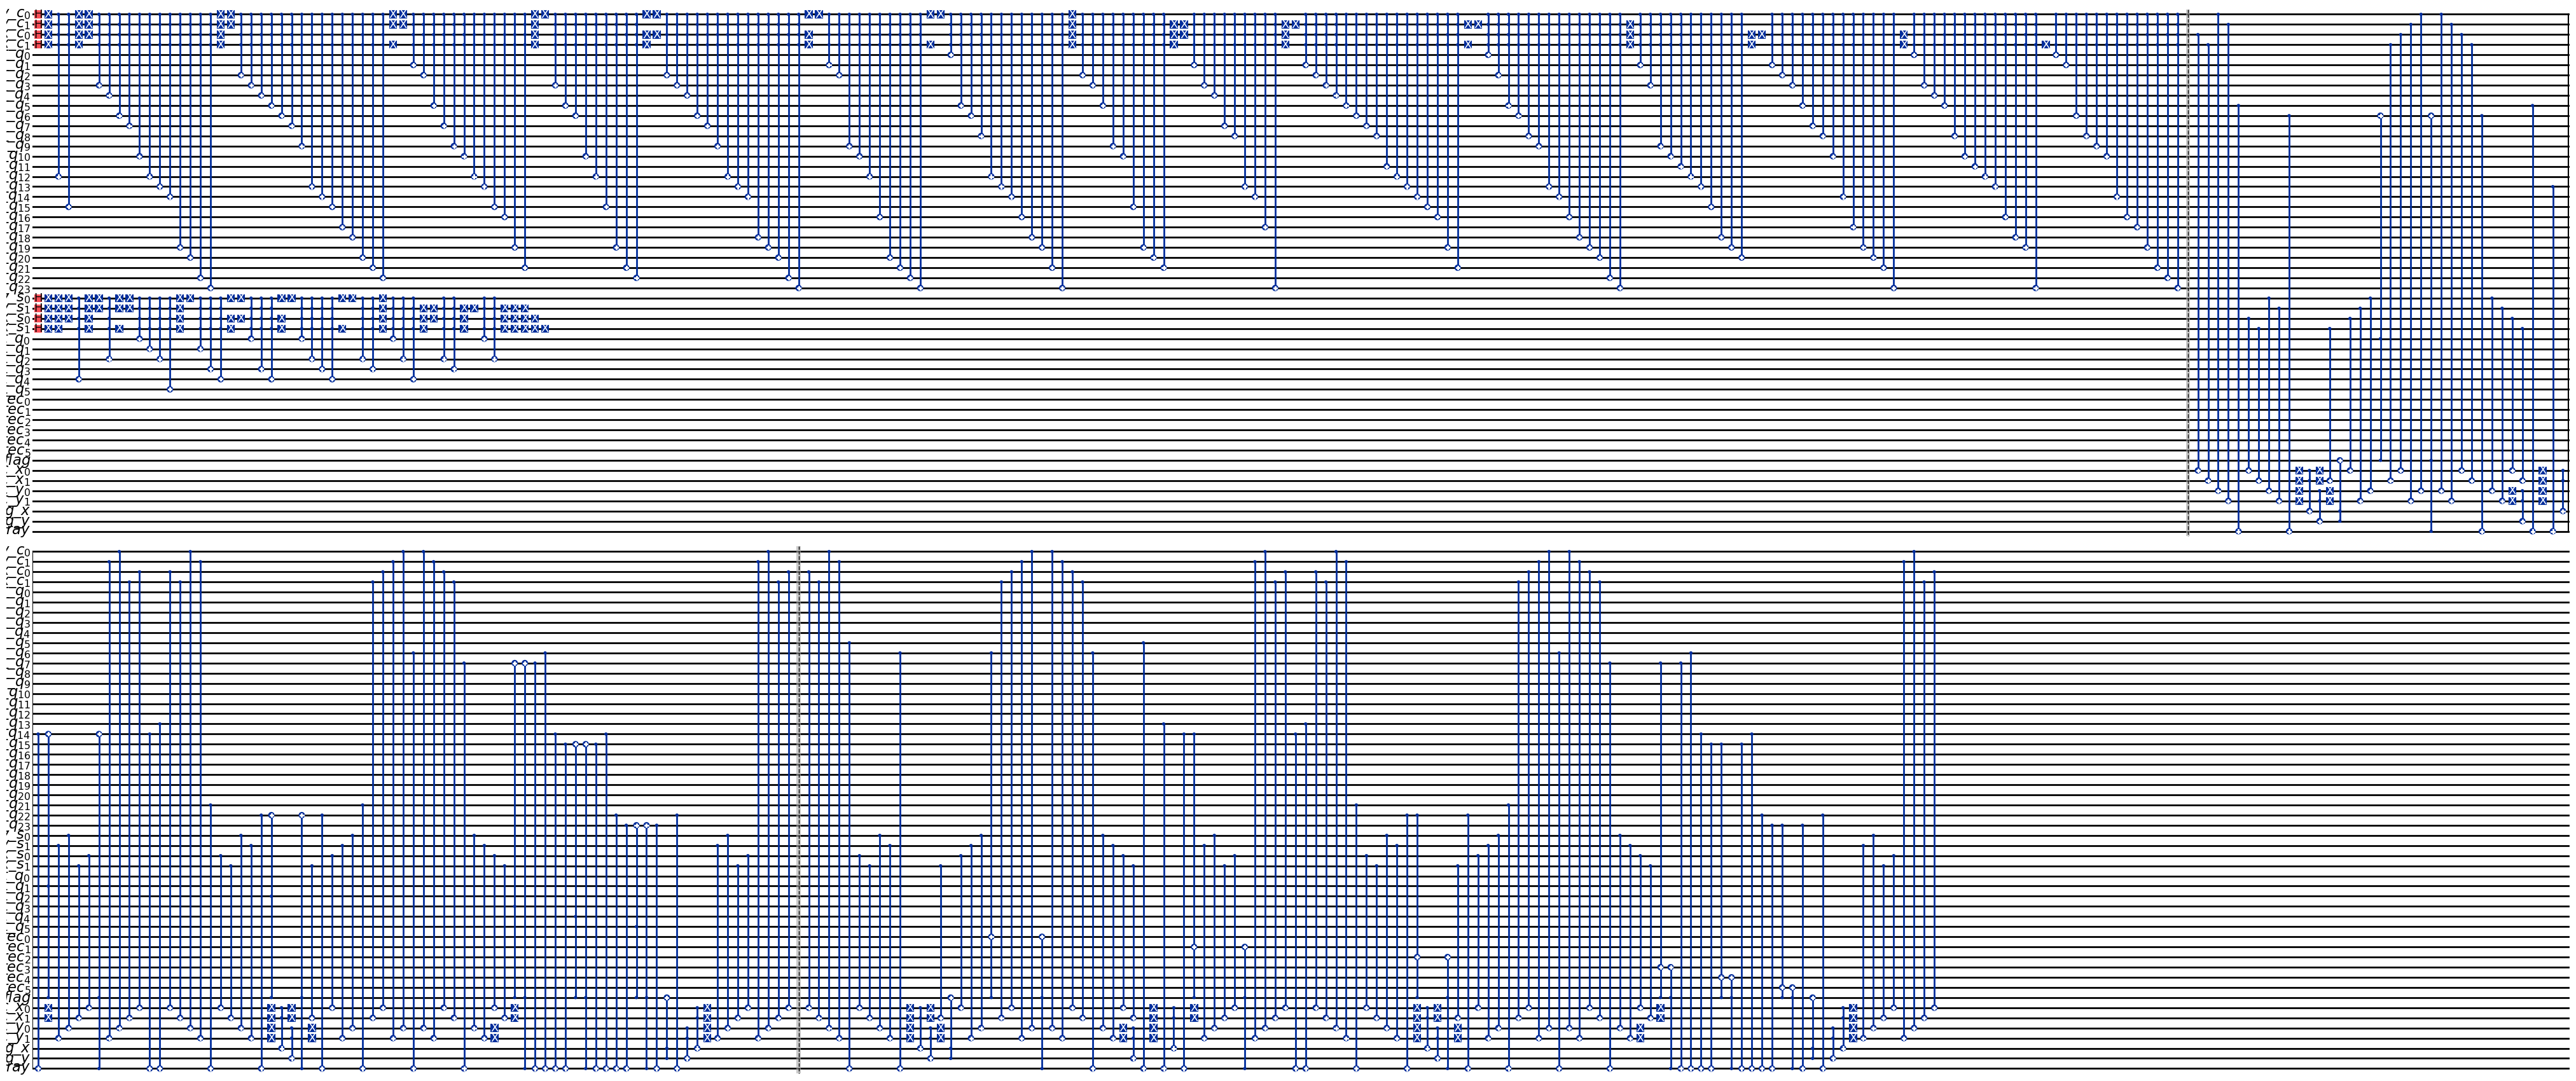

{'000000010110000 1101000000': 2, '000000010101111 0101000000': 5, '000000011110001 1111000000': 2, '000000000110001 1100000000': 5, '000000001001100 0010000000': 7, '000000000100100 0100000000': 4, '000000010100111 0101000000': 5, '000000000000100 0000000000': 4, '000000010110010 1101000000': 5, '000000010101101 0101000000': 5, '000000001001000 0010000000': 4, '111111000110011 1100111111': 6, '000000001110001 1110000000': 6, '000000000111010 1100000000': 4, '000000001111000 1110000000': 6, '000000011000110 0011000000': 5, '000000000110010 1100000000': 4, '000000001000101 0010000000': 4, '000000001011011 1010000000': 5, '000000000011111 1000000000': 11, '000000000111000 1100000000': 6, '000000000110111 1100000000': 3, '000000001111100 1110000000': 6, '000000001100000 0110000000': 4, '000000011001110 0011000000': 10, '000000000000011 0000000000': 6, '000000010010010 1001000000': 4, '000000001001001 0010000000': 5, '000000000111011 1100000000': 5, '000000001110000 1110000000': 2, '000000

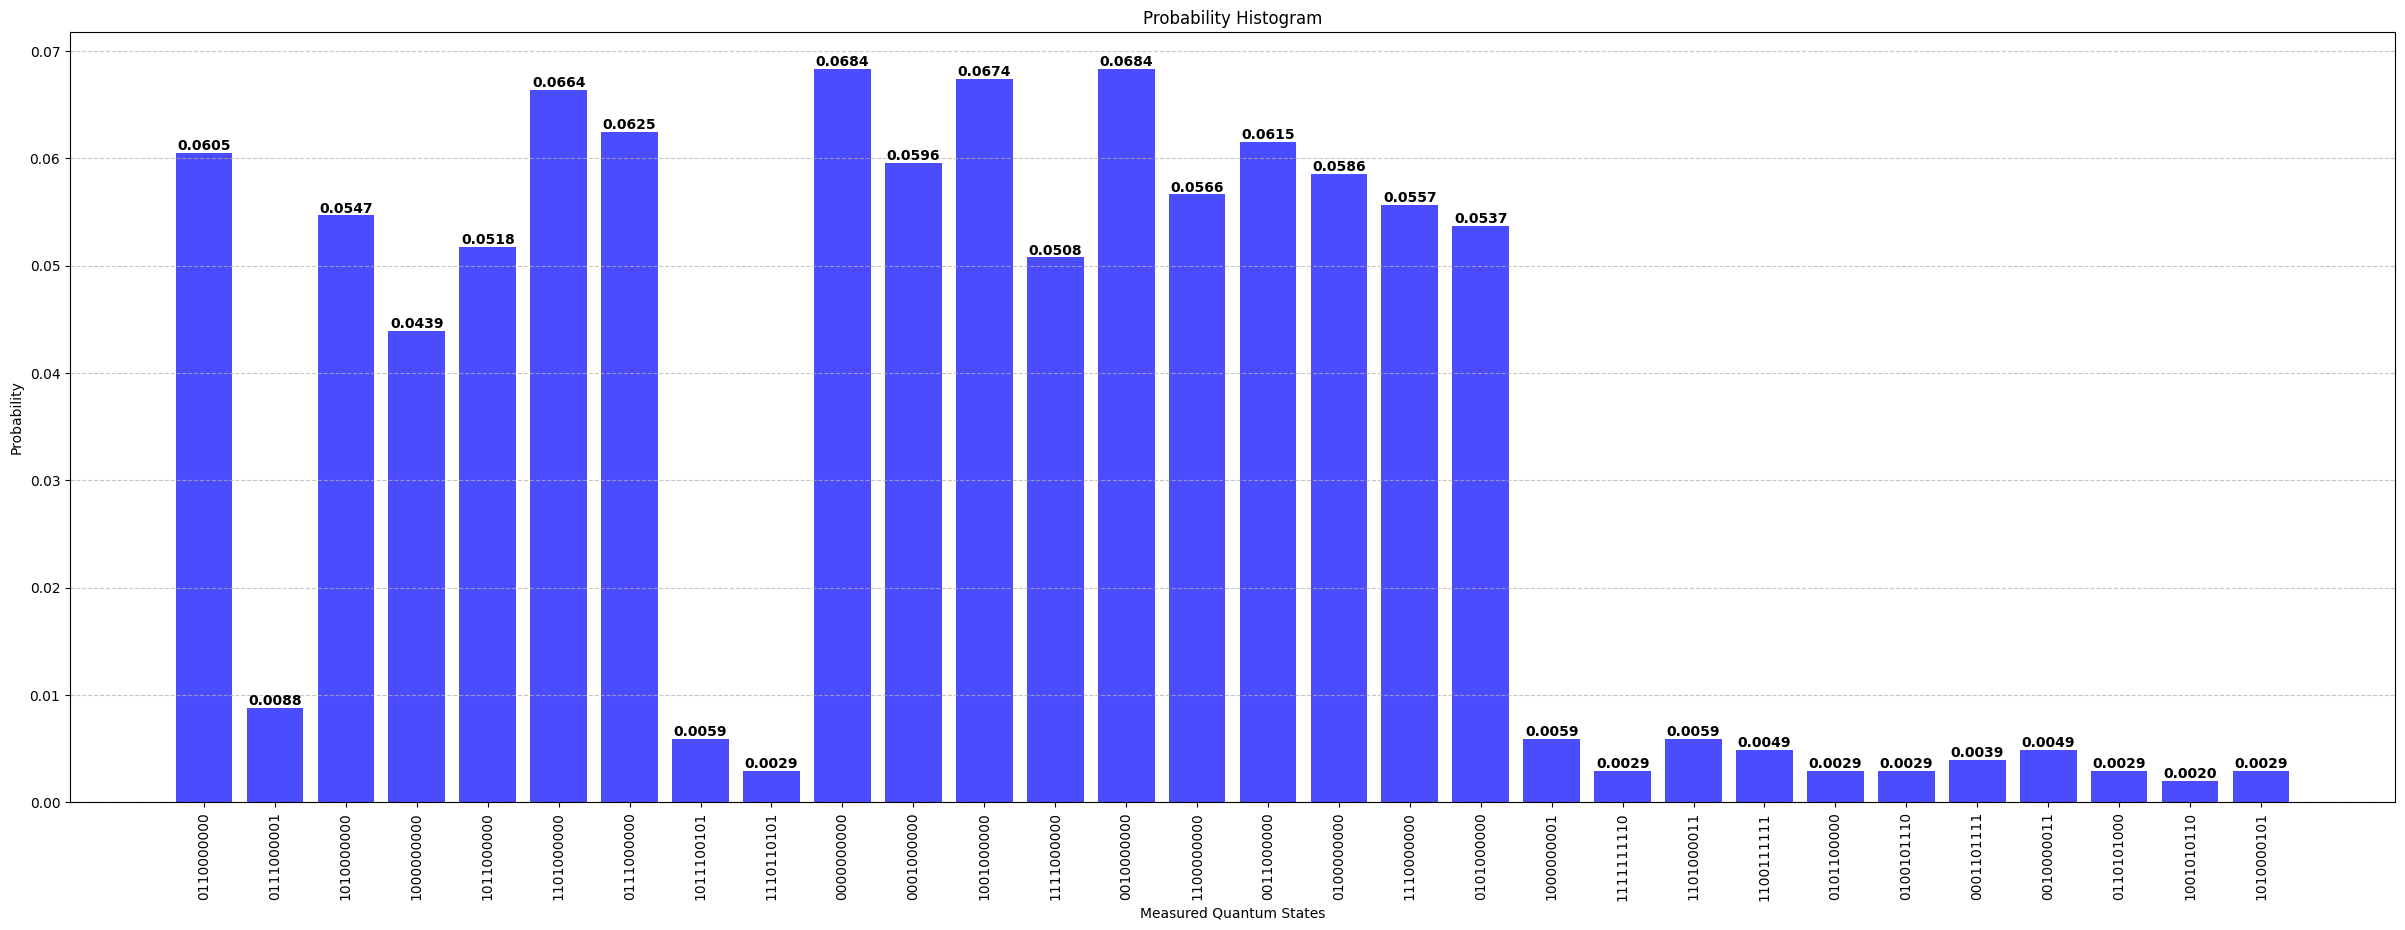

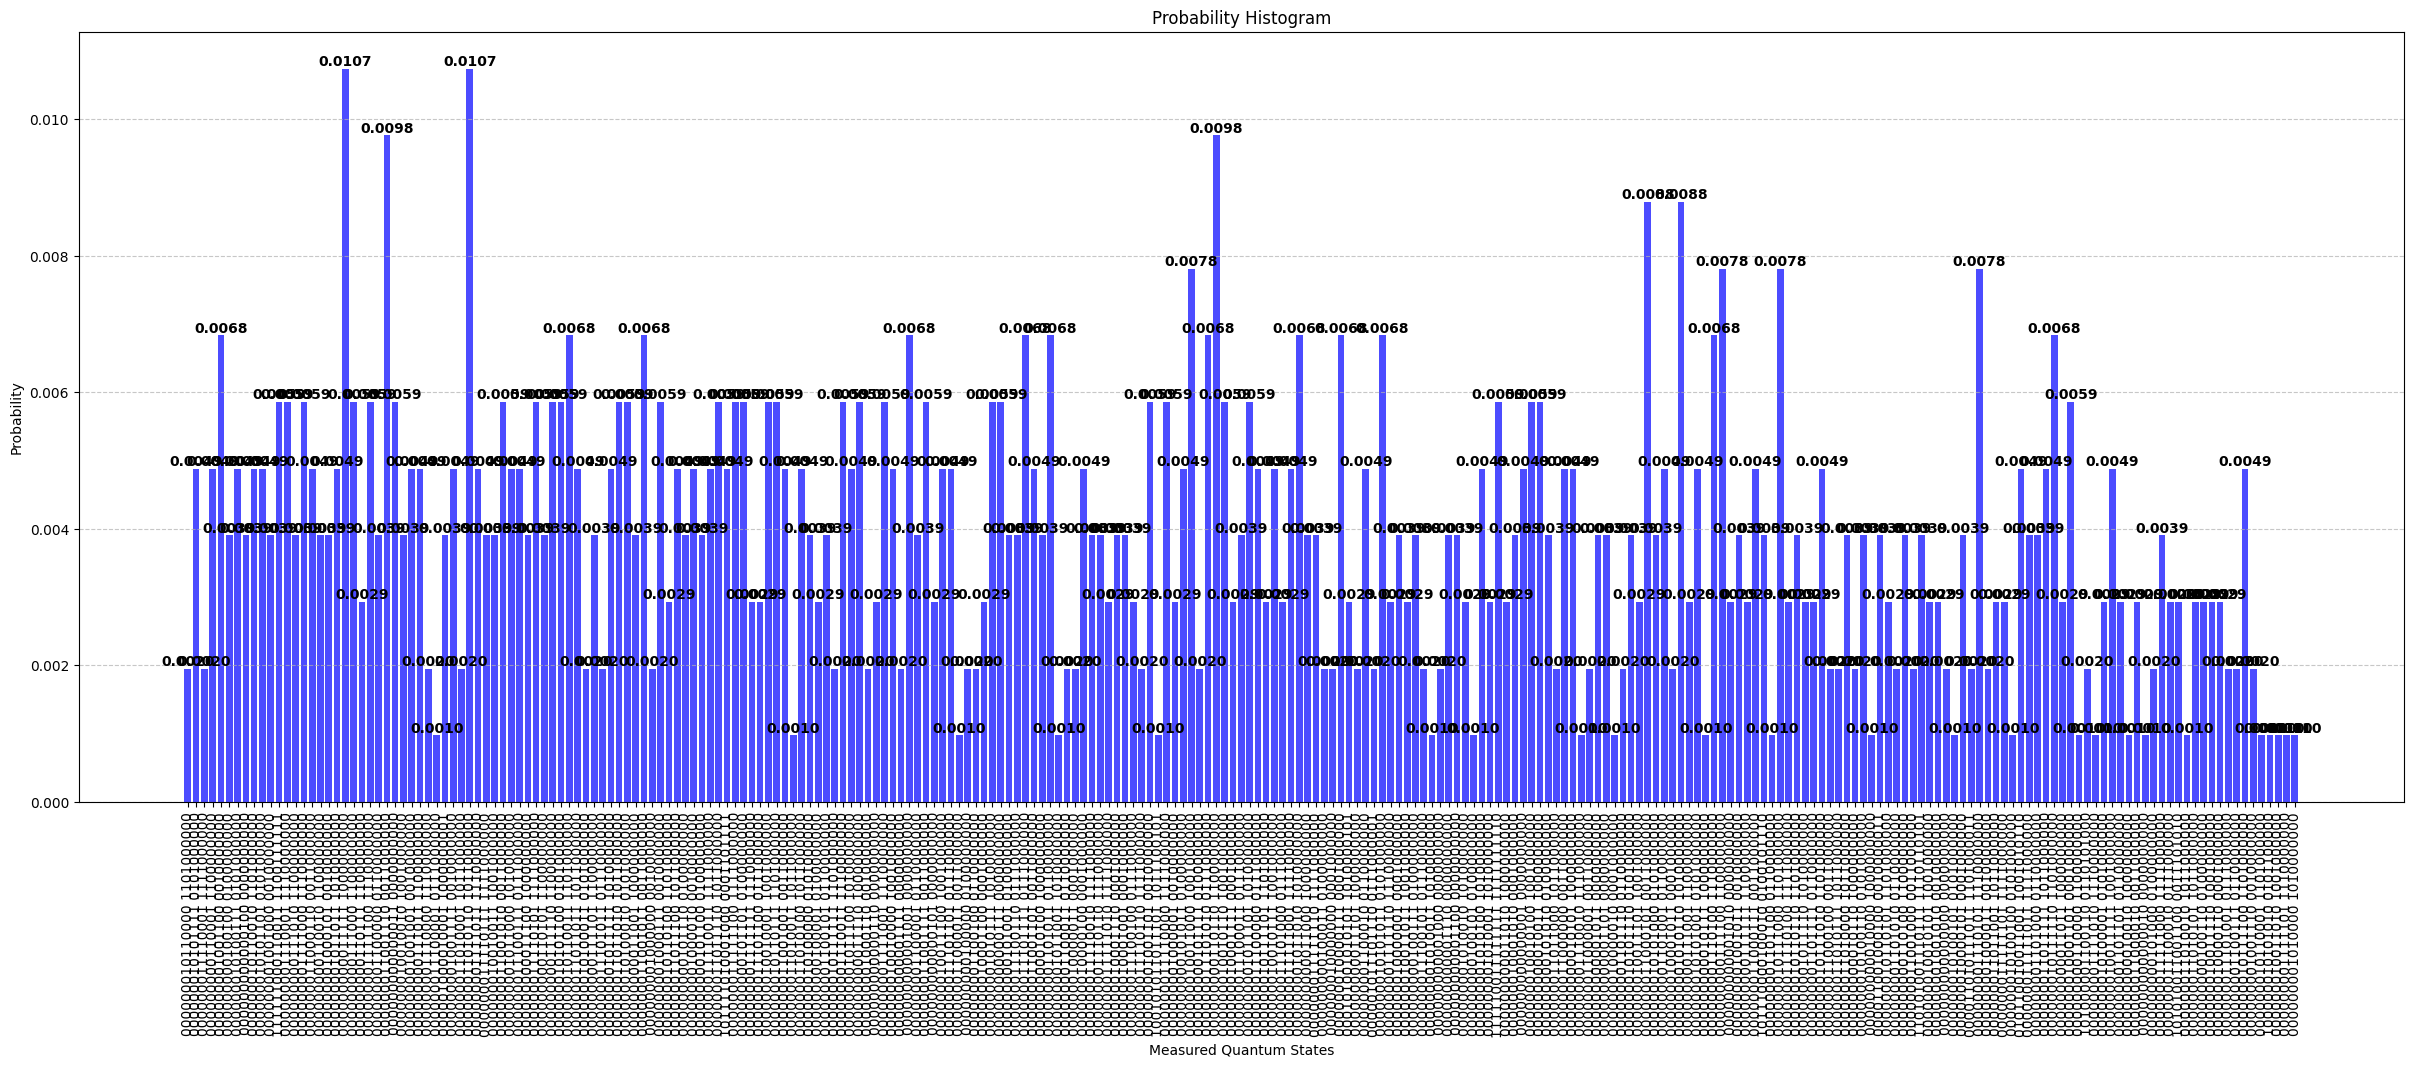

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 99.7500
Mean Squared Error (MSE): 14072.7500
Max Pixel Error : 202
PSNR (dB) : 6.65


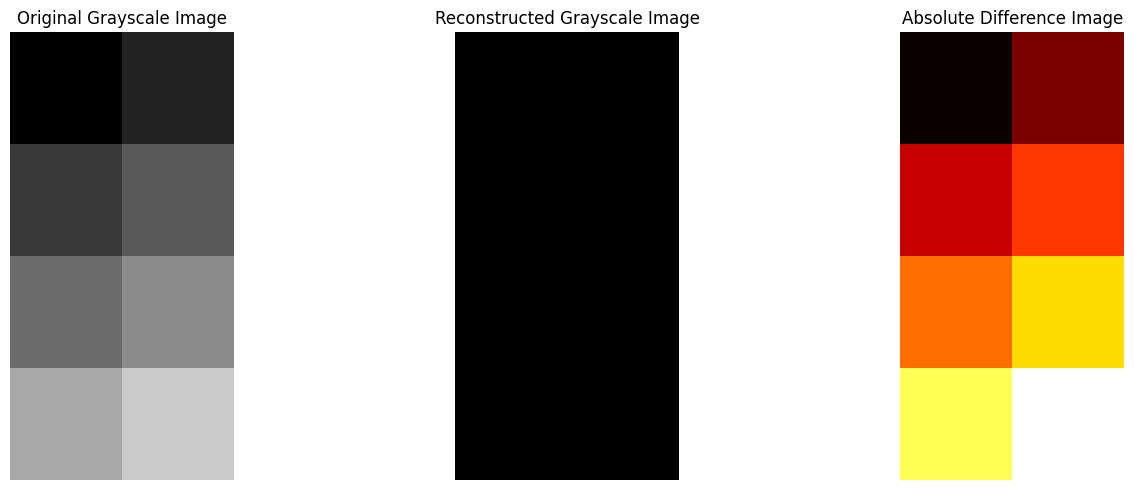

{'MAE': np.float64(99.75), 'MSE': np.float64(14072.75), 'MAX_ERROR': np.int64(202), 'PSNR': 6.6470138829985075}


In [29]:
master_function('cover_4x4.jpg','secret_4x2.jpg')

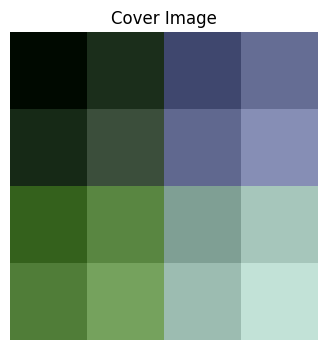

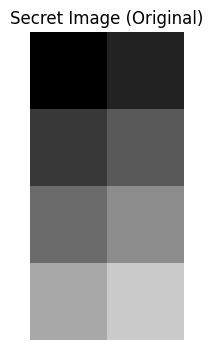

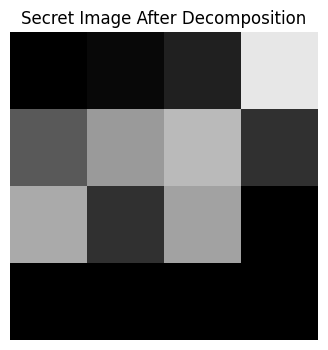

In [30]:
color_path = "cover_4x4.jpg"
secret_path = "secret_4x2.jpg"
# Loading and display cover image
img_rgb = load_color_image(color_path)
img_bin = preprocess_cover_to_8bit(color_path)
display_cover_image_binary(img_bin)
# Loading and displaying Original and Decomposed secret image
img_gray = load_gray_image(secret_path)
display_secret_before_decomposition(secret_path)
img_gray_6 = preprocess_grayscale_to_6bit_2d(secret_path,len(img_bin))
display_secret_after_decomposition(img_gray_6)
#Loading the values to QC

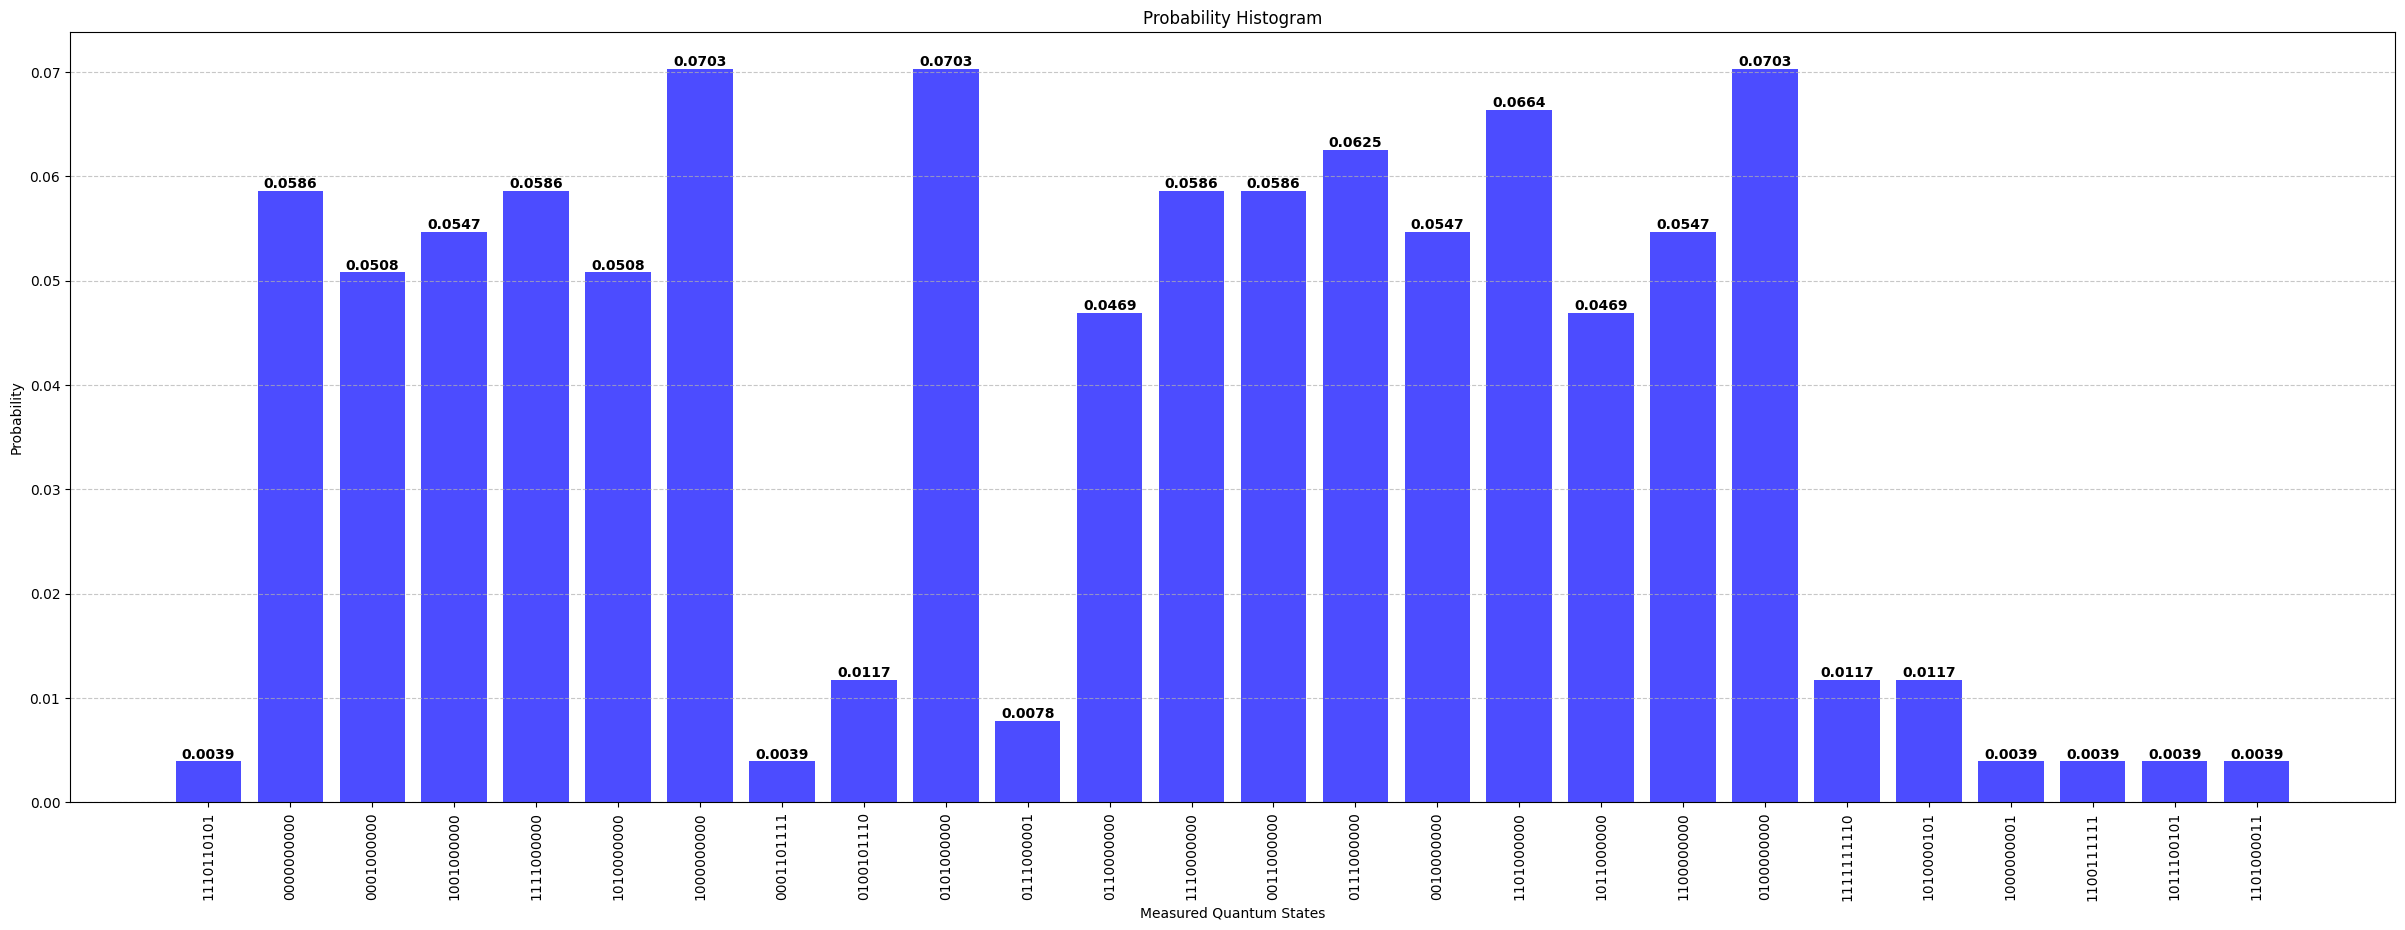

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 99.7500
Mean Squared Error (MSE): 14072.7500
Max Pixel Error : 202
PSNR (dB) : 6.65


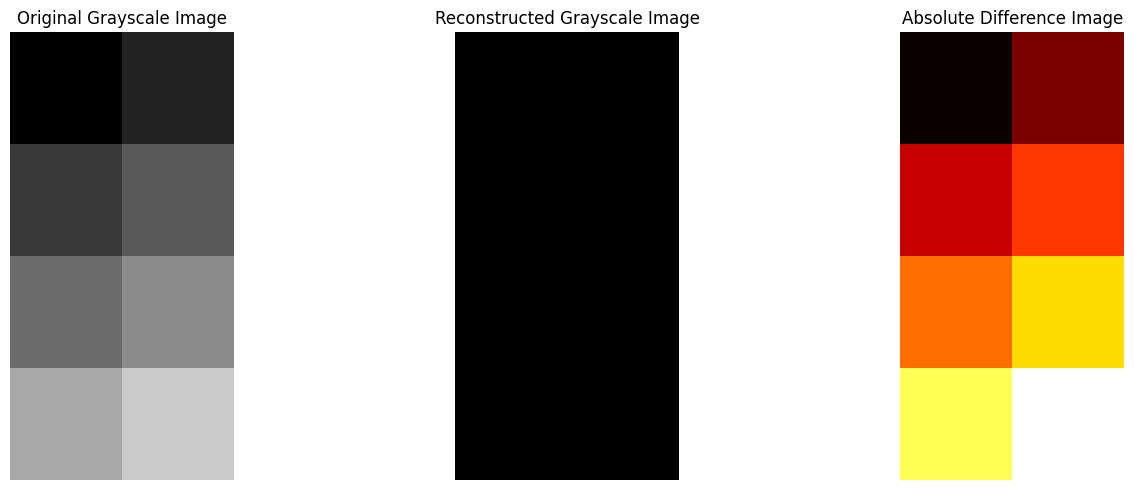

{'MAE': np.float64(99.75), 'MSE': np.float64(14072.75), 'MAX_ERROR': np.int64(202), 'PSNR': 6.6470138829985075}


In [31]:

#Loading the values to QC
qc ,regs = build_base_qc_CI_SI(img_bin,img_gray_6)
# Displaying
# display_large_circuit(qc, regs,"Loader Circuit")
# qc.barrier()
# Embedding circuit application
qc = add_global_embedding_to_qc(qc,regs)
# Displaying
# display_large_circuit(qc,regs,"After Embedding")
# qc.barrier()
# Extraction circuit
qc = add_global_extraction_to_qc(qc,regs)
# Displaying
# display_large_circuit(qc,regs,"After Extraction")

# Measuring the circuit
# counts = measure_and_run_secret(qc,regs,shots=1024)
from qiskit import ClassicalRegister
ky = len(regs["y_s"])
kx = len(regs["x_s"])
cl = ClassicalRegister(ky + kx + 6, "cl")
qc.add_register(cl)
idx=0
# secret bits (MSB → LSB)
for q in reversed(regs['si_rec']):
    qc.measure(q, cl[idx])
    idx+=1
# x (MSB → LSB)
for q in reversed(regs['x_s']):
    qc.measure(q, cl[idx])
    idx+=1
# y (MSB → LSB)
for q in reversed(regs['y_s']) :
    qc.measure(q, cl[idx])
    idx+=1

from qiskit_aer import AerSimulator
from qiskit import transpile
backend = AerSimulator(method="matrix_product_state")
tqc = transpile(qc,backend,optimization_level=3)

def run_cached(tqc, shots):
    result = backend.run(tqc, shots=shots).result()
    return result.get_counts()

counts_256  = run_cached(tqc, shots=256)
# counts_512  = run_cached(tqc, shots=512)
# counts_1024 = run_cached(tqc, shots=1024)

# Histogram
display_the_hist(counts_256)
# Reconstruction of secret image
img_rec = reconstruct_secret_grayscale(counts_256,
                                       ky=len(regs['y_s']),kx= len(regs['x_s']),
                                       Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                       Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )

# Displaying and comparing the Original and Reconstruction Image
metrics = display_and_compare_grayscale(img_gray,img_rec,show_diff=True) 
print(metrics)


In [ ]:
counts_512  = run_cached(tqc, shots=512)

# Histogram
display_the_hist(counts_512)
# Reconstruction of secret image
img_rec2 = reconstruct_secret_grayscale(counts_512,
                                       ky=len(regs['y_s']),kx= len(regs['x_s']),
                                       Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                       Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )

# Displaying and comparing the Original and Reconstruction Image
metrics2 = display_and_compare_grayscale(img_gray,img_rec2,show_diff=True) 
print(metrics2)

In [ ]:
# counts_256  = run_cached(tqc, shots=256)
# counts_512  = run_cached(tqc, shots=512)
counts_1024 = run_cached(tqc, shots=1024)

# Histogram
display_the_hist(counts_1024)
# Reconstruction of secret image
img_rec3 = reconstruct_secret_grayscale(counts_1024,
                                       ky=len(regs['y_s']),kx= len(regs['x_s']),
                                       Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                       Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )

# Displaying and comparing the Original and Reconstruction Image
metrics3 = display_and_compare_grayscale(img_gray,img_rec3,show_diff=True) 
print(metrics3)

NameError: name 'run_cached' is not defined

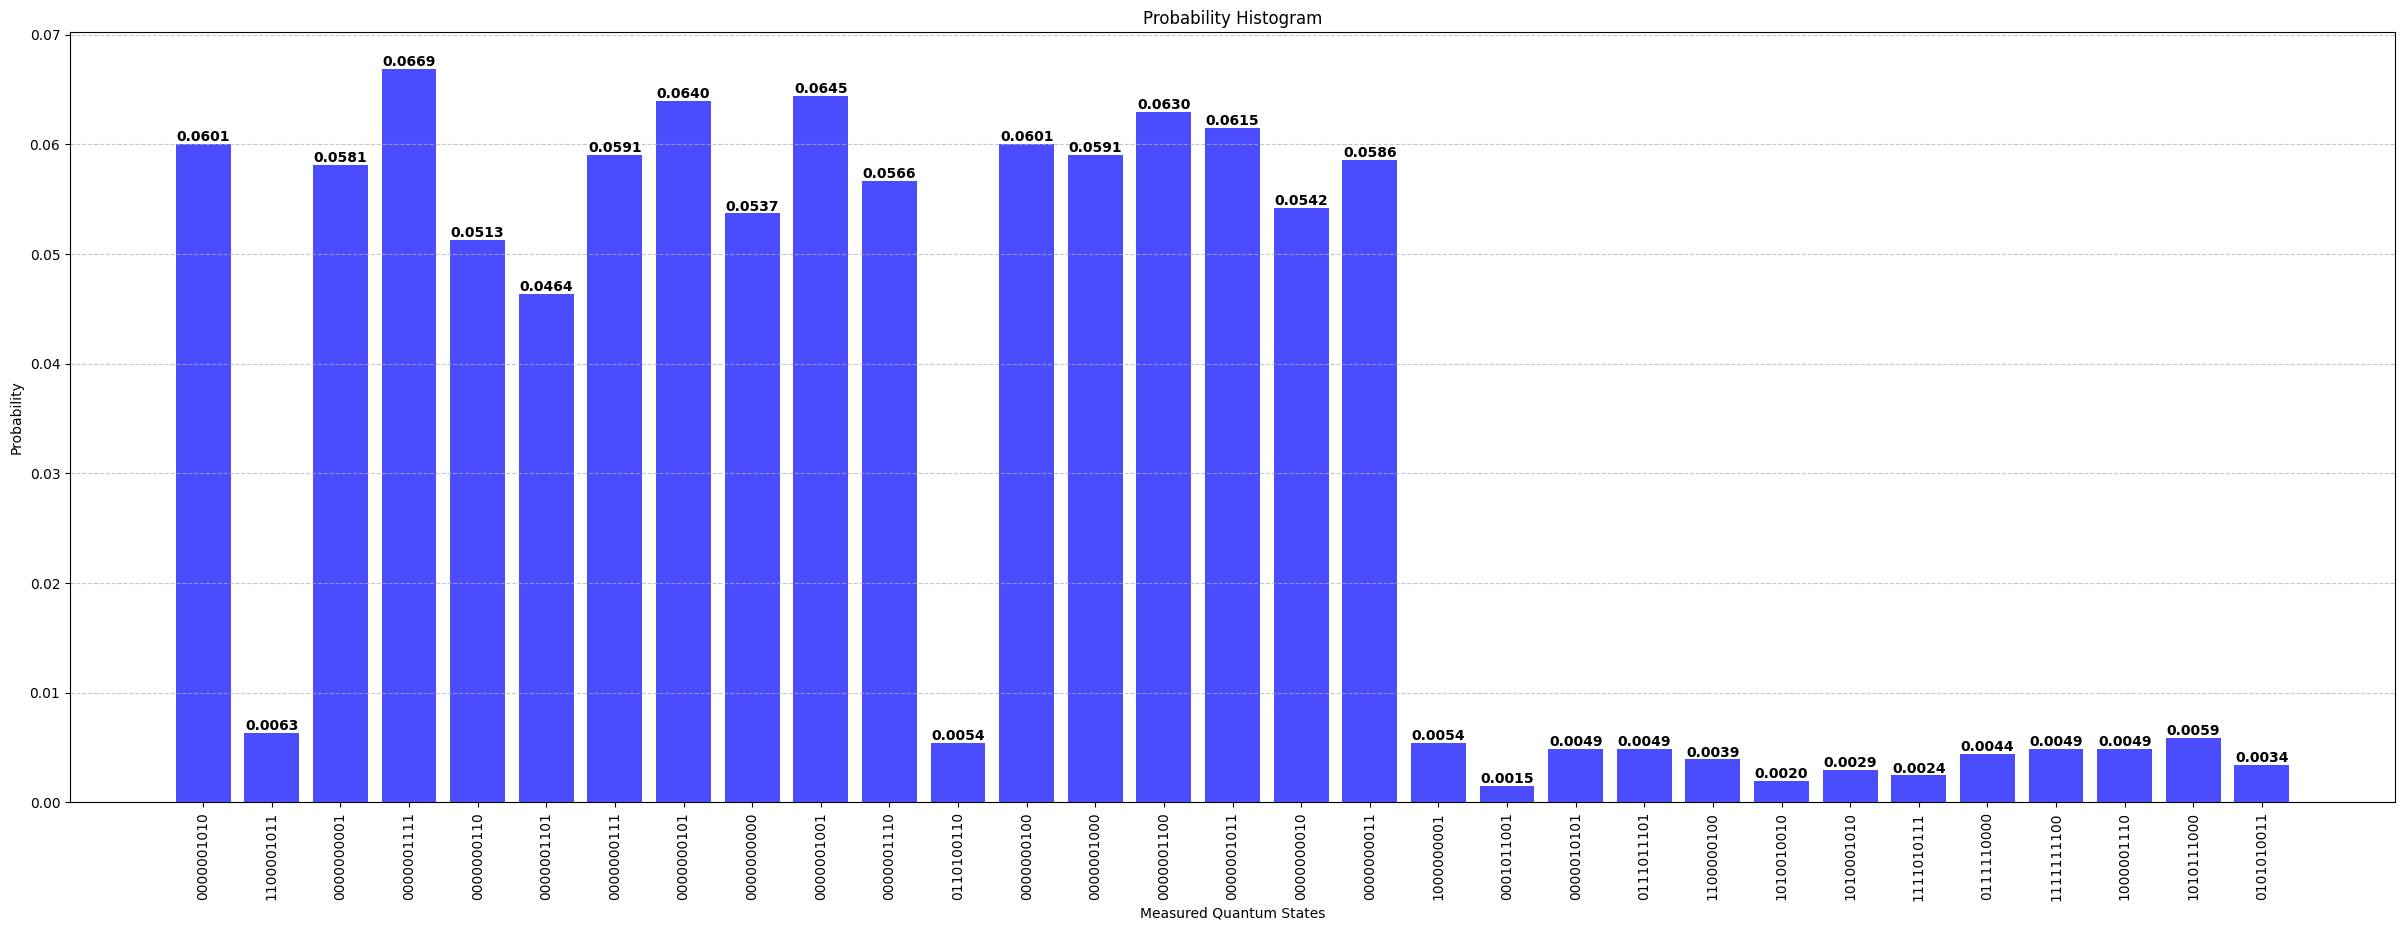

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 92.0000
Mean Squared Error (MSE): 11502.5000
Max Pixel Error : 188
PSNR (dB) : 7.52


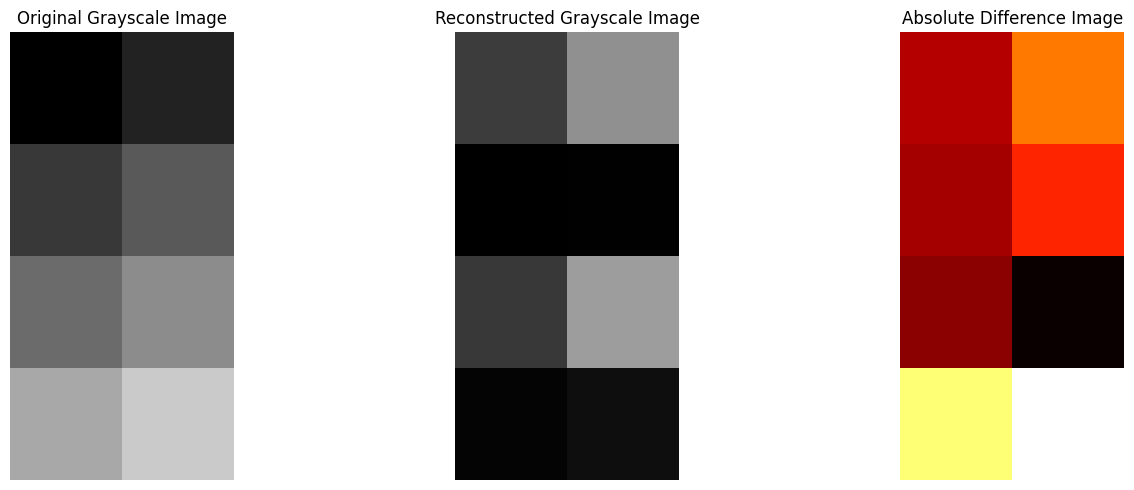

{'MAE': np.float64(92.0), 'MSE': np.float64(11502.5), 'MAX_ERROR': np.int64(188), 'PSNR': 7.522881189310766}


In [ ]:
counts_2048 = run_cached(tqc, shots=2048)

# Histogram
display_the_hist(counts_2048)
# Reconstruction of secret image
img_rec4 = reconstruct_secret_grayscale(counts_2048,
                                       ky=len(regs['y_s']),kx= len(regs['x_s']),
                                       Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                       Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )

# Displaying and comparing the Original and Reconstruction Image
metrics4 = display_and_compare_grayscale(img_gray,img_rec4,show_diff=True) 
print(metrics4)

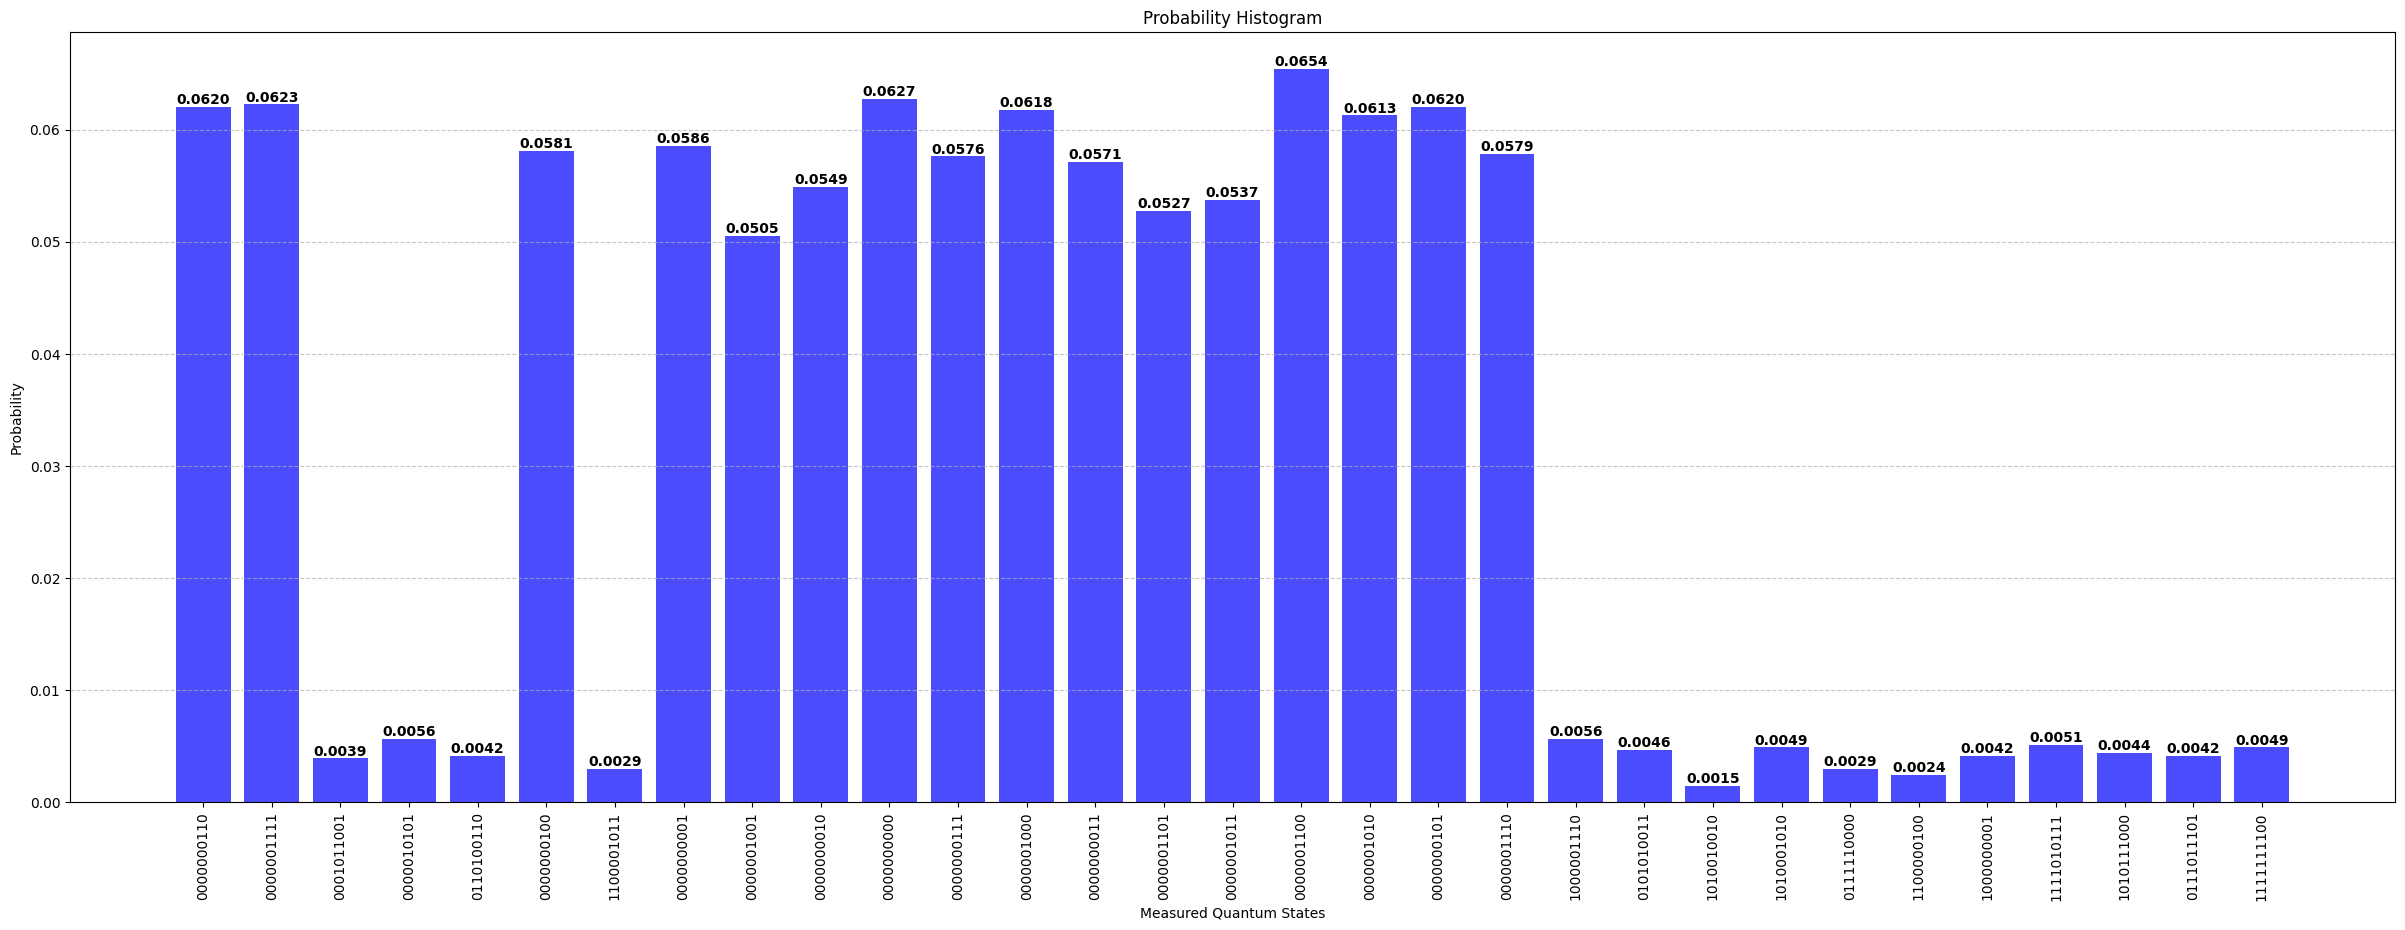

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 85.5000
Mean Squared Error (MSE): 10125.5000
Max Pixel Error : 200
PSNR (dB) : 8.08


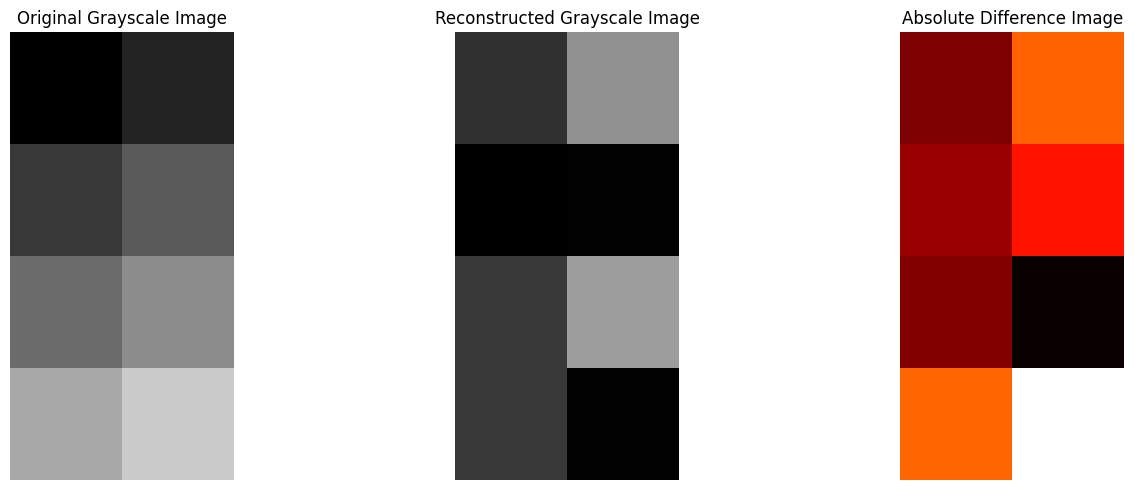

{'MAE': np.float64(85.5), 'MSE': np.float64(10125.5), 'MAX_ERROR': np.int64(200), 'PSNR': 8.076638828696519}


In [ ]:
counts_4096 = run_cached(tqc, shots=4096)

# Histogram
display_the_hist(counts_4096)
# Reconstruction of secret image
img_rec5 = reconstruct_secret_grayscale(counts_4096,
                                       ky=len(regs['y_s']),kx= len(regs['x_s']),
                                       Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                       Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )

# Displaying and comparing the Original and Reconstruction Image
metrics5 = display_and_compare_grayscale(img_gray,img_rec5,show_diff=True) 
print(metrics5)